<a href="https://colab.research.google.com/github/Khomiakov7706/Hierarchy_Analysis_Method/blob/develop/Requirement_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация формулировок требований

In [103]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn import metrics

plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', 500)

In [5]:
#@title Data URL. { display-mode: "form" }
data_url = 'https://raw.githubusercontent.com/Khomiakov7706/requirements_analysis/main/train_test_withcols1.csv' #@param {type: 'string'}

In [6]:
data = pd.read_csv(data_url)

In [7]:
data = data.drop('req_type', 1)
data = data.drop('test_scenario', 1)
data = data.rename(columns={'requirement': 'requirement_text'})

<ipython-input-7-a88a7e1872b6>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('req_type', 1)
<ipython-input-7-a88a7e1872b6>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('test_scenario', 1)


In [8]:
requirement_classes = list(data.columns[2:].values)

In [9]:
all_words = data['requirement_text'].str.split(expand=True).unstack().value_counts()

# Лемматизация

In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
def lemmatization(text):
    '''a function for lemmatization'''
    text = [lemmatizer.lemmatize(word.lower()) for word in text.split()]
    # joining the list of words with space separator
    return " ".join(text)

In [12]:
data['lemmatized_requirement'] = data['requirement_text'].apply(lemmatization)

Убираем стоп-слова

In [13]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words 
    text = [word for word in text.split() if word not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [15]:
data['lemmatized_requirement'] = data['lemmatized_requirement'].apply(stopwords)

In [16]:
import re
regex = re.compile('[^a-zA-Z а-яА-Я]')

In [17]:
data.lemmatized_requirement = data.lemmatized_requirement.apply(lambda x: regex.sub('',x))

# Выявление признаков из датасета

## Синтетические признаки

составляем набор признаков на основе текста Dataframe

Количество слов в тексте требования 

In [18]:
data['words_in_requirement'] = (
    data['requirement_text'].str.split().apply(len))

Кол-во слов в тексте лемматизированного требования

In [19]:
data['words_in_lemmatized_req'] = (
    data['lemmatized_requirement'].str.split().apply(len))

Кол-во исключенных слов при лемматизации

In [20]:
data['words_diffence'] = (
    data['words_in_requirement']-data['words_in_lemmatized_req'])

In [21]:
additional_parameters = data.columns[-3:]

## Слова-признаки

Составляем словарь слов для разных классов с указанием количества используемых слов

In [24]:
class_dict = dict()
for c in range(len(requirement_classes)):
    class_dict[requirement_classes[c]] = data[data[requirement_classes[c]]==1]['lemmatized_requirement'].str.split(expand=True).unstack().value_counts().head(15)

Составляем мешок уникальных слов для каждого класса

In [25]:
bag_of_word = []
for i in requirement_classes:
    for j in class_dict[i].index:
        if not (j in bag_of_word):
            bag_of_word.append(j)

Выписываем наиболее используемые слова как признаки

In [ ]:
for word in bag_of_word:
    data[word]=data['lemmatized_requirement'].apply(lambda x: x.count(str (' ' + word + ' ')))

Создаем разметку данных

In [27]:
target = requirement_classes
features = bag_of_word
for i in additional_parameters:
    features.append(i)

# Разбиение на тестовую и валидационную выборки для каждого класса требований

Всего 26 классов

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
def split_train_test (dataframe_, target_, features_):
        
        X_train, X_test, y_train, y_test = train_test_split(dataframe_[features_],dataframe_[target_],test_size=0.2, random_state=77, stratify=dataframe_[target_])
        
        return X_train, X_test, y_train, y_test

In [30]:
class_dict['Verification of Account Details and Settings'].index

Index(['user', 'contact', 'account', 'information', 'field', 'shall', 'number',
       'email', 'profile', 'website', 'include', 'phone', 'address', 'id',
       'password'],
      dtype='object')

In [31]:
X_class_train = dict()
X_class_test = dict()
y_class_train = dict()
y_class_test = dict()

for cl in requirement_classes:
    X_class_train[cl],X_class_test[cl],y_class_train[cl],y_class_test[cl]=split_train_test(data, cl, class_dict[cl].index)

# Нормализация

In [32]:
from sklearn.preprocessing import MinMaxScaler


Нормализация обучающей выборки

In [33]:
scaler = dict()
scaler_params = dict()
for cl in requirement_classes:
    scaler[cl] = MinMaxScaler()
    X_class_train[cl] = scaler[cl].fit_transform(X_class_train[cl])

Нормализация тестовой выборки на сонове парамтеров обучающей

In [34]:
scaler_ = MinMaxScaler()
for cl in requirement_classes:
#    scaler[cl].get_params()
    X_class_test[cl]=scaler[cl].transform(X_class_test[cl])

# Обучение модели на базе Bag Of Words

Так как классификация будет проводиться по каждому из классов независимо, разбиение на тестовую и обучающую выборки будет проводиться для каждого из классов отдельно

In [35]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
model_class_lr = dict()
model_lr_ = LogisticRegression() # Используем модель с параметрами по умолчанию

for cl in range(len(requirement_classes)):
    model_lr_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_lr[requirement_classes[cl]] = model_lr_

Наивный Байес

In [36]:
from sklearn.naive_bayes import GaussianNB
model_nb_ = GaussianNB() # Используем модель с параметрами по умолчанию

model_class_nb = dict()
for cl in range(len(requirement_classes)):
    model_nb_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_nb[requirement_classes[cl]] = model_nb_

k-ближайших соседей

In [37]:
from sklearn.neighbors import KNeighborsClassifier
model_knn_ = KNeighborsClassifier() # Используем модель с параметрами по умолчанию

model_class_knn = dict()
for cl in range(len(requirement_classes)):
    model_knn_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_knn[requirement_classes[cl]] = model_knn_

Метод решающих деревьев

In [38]:
from sklearn.tree import DecisionTreeClassifier
model_dtc_ = DecisionTreeClassifier() # Используем модель с параметрами по умолчанию

model_class_dtc = dict()
for cl in range(len(requirement_classes)):
    model_dtc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_dtc[requirement_classes[cl]] = model_dtc_

Метод поддерживающих векторов

In [39]:
from sklearn.svm import SVC
model_svc_ = SVC() # Используем модель с параметрами по умолчанию

model_class_svc = dict()
for cl in range(len(requirement_classes)):
    model_svc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_svc[requirement_classes[cl]] = model_svc_

Случайный лес

In [40]:
from sklearn.ensemble import RandomForestClassifier
model_rf_ = RandomForestClassifier() # Используем модель с параметрами по умолчанию

model_class_rf = dict()
for cl in range(len(requirement_classes)):
    model_rf_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_rf[requirement_classes[cl]] = model_rf_

## Расчет accuracy and confusion matrix метрик для каждого класса и метода

In [41]:
from sklearn.metrics import accuracy_score

In [117]:
#@title linear regression

lr_accuracy_test = dict()
lr_accuracy_train = dict()
lr_train_confusion_matrix = dict()
lr_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_lr[cl].predict(X_class_train[cl])
    test_predict = model_class_lr[cl].predict(X_class_test[cl])

    lr_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    lr_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    lr_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    lr_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [118]:
#@title naive bias

nb_accuracy_test = dict()
nb_accuracy_train = dict()
nb_train_confusion_matrix = dict()
nb_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_nb[cl].predict(X_class_train[cl])
    test_predict = model_class_nb[cl].predict(X_class_test[cl])

    nb_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    nb_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    nb_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    nb_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [121]:
#@title k nearest neighbours

knn_accuracy_test = dict()
knn_accuracy_train = dict()

knn_train_confusion_matrix = dict()
knn_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_knn[cl].predict(X_class_train[cl])
    test_predict = model_class_knn[cl].predict(X_class_test[cl])

    knn_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    knn_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
    
    knn_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    knn_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)

In [122]:
#@title decision trees


dtc_accuracy_test = dict()
dtc_accuracy_train = dict()
dtc_train_confusion_matrix = dict()
dtc_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_dtc[cl].predict(X_class_train[cl])
    test_predict = model_class_dtc[cl].predict(X_class_test[cl])

    dtc_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    dtc_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    dtc_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    dtc_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [123]:
#@title support vector machine

svc_accuracy_test = dict()
svc_accuracy_train = dict()
svc_train_confusion_matrix = dict()
svc_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_svc[cl].predict(X_class_train[cl])
    test_predict = model_class_svc[cl].predict(X_class_test[cl])

    svc_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    svc_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
    
    svc_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    svc_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
  

In [116]:
#@title random forest

rf_accuracy_test = dict()
rf_accuracy_train = dict()
rf_train_confusion_matrix = dict()
rf_test_confusion_matrix = dict()

for cl in requirement_classes:
  train_predict = model_class_rf[cl].predict(X_class_train[cl])
  test_predict = model_class_rf[cl].predict(X_class_test[cl])
  
  rf_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
  rf_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
  
  rf_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
  rf_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

## Confusion matrix

In [124]:
#@title variables declaration
classifiers = list({'lr', 'nb', 'knn', 'dtc', 'svc', 'rf'})
mean_train_accuracy = dict()
mean_test_accuracy = dict()

for i in classifiers:
    mean_train_accuracy[i] = 0.0
    mean_test_accuracy[i] = 0.0

In [148]:
#@title Confusion matrix function definition
cf = dict()
def confusion_matrix_by_classifier (classifier, confusion_matrix):
  cf[classifier] = 0
  for cl in requirement_classes:
    cf[classifier] += confusion_matrix[cl]
  print('confusion matrix for ', classifier, ' classifier:\n', cf[classifier], '\n')

In [152]:
#@title Confusion Matrixes for different classifiers
lr_confusionMatrix = confusion_matrix_by_classifier('lr', lr_test_confusion_matrix)
nb_confusionMatrix = confusion_matrix_by_classifier('nb', nb_test_confusion_matrix)
svc_confusionMatrix = confusion_matrix_by_classifier('svc', svc_test_confusion_matrix)
rf_confusionMatrix = confusion_matrix_by_classifier('rf', rf_test_confusion_matrix)
dtc_confusion_matrix = confusion_matrix_by_classifier('dtc', dtc_test_confusion_matrix)
knn_confusion_matrix = confusion_matrix_by_classifier('knn', knn_test_confusion_matrix)

confusion matrix for  lr  classifier:
 [[6769   18]
 [ 414   27]] 

confusion matrix for  nb  classifier:
 [[5803  984]
 [ 240  201]] 

confusion matrix for  svc  classifier:
 [[6660  127]
 [ 434    7]] 

confusion matrix for  rf  classifier:
 [[6422  365]
 [ 366   75]] 

confusion matrix for  dtc  classifier:
 [[6312  475]
 [ 364   77]] 

confusion matrix for  knn  classifier:
 [[6514  273]
 [ 402   39]] 



##Mean Accuracy

In [154]:
#@title logistic regression
print('Логистическая регрессия')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',lr_accuracy_train[cl])
    print('Точность на тестовой выборке: ', lr_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['lr'] += lr_accuracy_train[cl]
    mean_test_accuracy['lr'] += lr_accuracy_test[cl]

mean_train_accuracy['lr'] = mean_train_accuracy['lr']/len(requirement_classes)
mean_test_accuracy['lr'] = mean_test_accuracy['lr']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['lr'])
print ('mean test accuracy: ', mean_test_accuracy['lr'])

Логистическая регрессия
mean train accuracy:  0.9831265165382486
mean test accuracy:  0.983711847090375


In [155]:
#@title naive bias

print('Наивный Байес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',nb_accuracy_train[cl])
    print('Точность на тестовой выборке: ', nb_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['nb'] += nb_accuracy_train[cl]
    mean_test_accuracy['nb'] += nb_accuracy_test[cl]
mean_train_accuracy['nb'] = mean_train_accuracy['nb']/len(requirement_classes)
mean_test_accuracy['nb'] = mean_test_accuracy['nb']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['nb'])
print ('mean test accuracy: ', mean_test_accuracy['nb'])

Наивный Байес
mean train accuracy:  0.8285486995019371
mean test accuracy:  0.8306585500830106


In [156]:
#@title KNN

print('k-ближайших соседей')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',knn_accuracy_train[cl])
    print('Точность на тестовой выборке: ', knn_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['knn'] += knn_accuracy_train[cl]
    mean_test_accuracy['knn'] += knn_accuracy_test[cl]
mean_train_accuracy['knn'] = mean_train_accuracy['knn']/len(requirement_classes)
mean_test_accuracy['knn'] = mean_test_accuracy['knn']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['knn'])
print ('mean test accuracy: ', mean_test_accuracy['knn'])

k-ближайших соседей
mean train accuracy:  0.9043303818483677
mean test accuracy:  0.90661317100166


In [157]:
#@title decision trees

print('Метод решающих деревьев')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',dtc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', dtc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['dtc'] += dtc_accuracy_train[cl]
    mean_test_accuracy['dtc'] += dtc_accuracy_test[cl]
mean_train_accuracy['dtc'] = mean_train_accuracy['dtc']/len(requirement_classes)
mean_test_accuracy['dtc'] = mean_test_accuracy['dtc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['dtc'])
print ('mean test accuracy: ', mean_test_accuracy['dtc'])

Метод решающих деревьев
mean train accuracy:  0.8811220254565577
mean test accuracy:  0.8839236303265081


In [158]:
#@title support vector machine)

print('Метод опорных векторов')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',svc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', svc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['svc'] += svc_accuracy_train[cl]
    mean_test_accuracy['svc'] += svc_accuracy_test[cl]
mean_train_accuracy['svc'] = mean_train_accuracy['svc']/len(requirement_classes)
mean_test_accuracy['svc'] = mean_test_accuracy['svc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['svc'])
print ('mean test accuracy: ', mean_test_accuracy['svc'])

Метод опорных векторов
mean train accuracy:  0.9228002213613724
mean test accuracy:  0.9223851687880463


In [159]:
#@title random forest

print('Случайный лес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',rf_accuracy_train[cl])
    print('Точность на тестовой выборке: ', rf_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['rf'] += rf_accuracy_train[cl]
    mean_test_accuracy['rf'] += rf_accuracy_test[cl]
mean_train_accuracy['rf'] = mean_train_accuracy['rf']/len(requirement_classes)
mean_test_accuracy['rf'] = mean_test_accuracy['rf']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['rf'])
print ('mean test accuracy: ', mean_test_accuracy['rf'])

Случайный лес
mean train accuracy:  0.8986925843940232
mean test accuracy:  0.8988655229662424


# Визуализация результатов

методом линейной регрессии получилась следующая точность классификации для каждого класса:

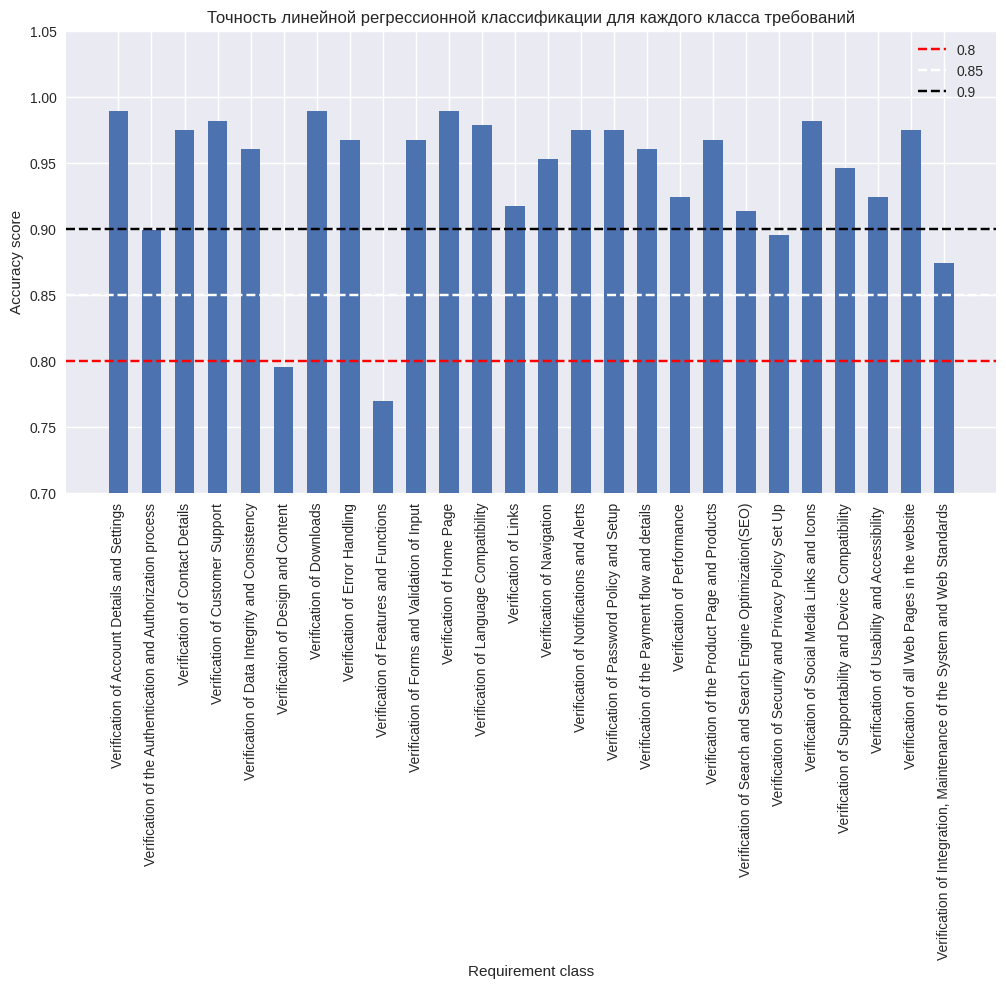

In [98]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(requirement_classes,lr_accuracy_test.values(), width=0.6)
plt.title('Точность линейной регрессионной классификации для каждого класса требований')
a = plt.xticks(rotation=90)
plt.axhline(0.8,c='r',linestyle='--',label='0.8')
plt.axhline(0.85,c='w',linestyle='--',label='0.85')
plt.axhline(0.9,c='black',linestyle='--',label='0.9')
plt.ylim(0.7, 1.05) # adjust y axis limits
plt.legend()
plt.xlabel('Requirement class')
plt.ylabel('Accuracy score')
plt.show()

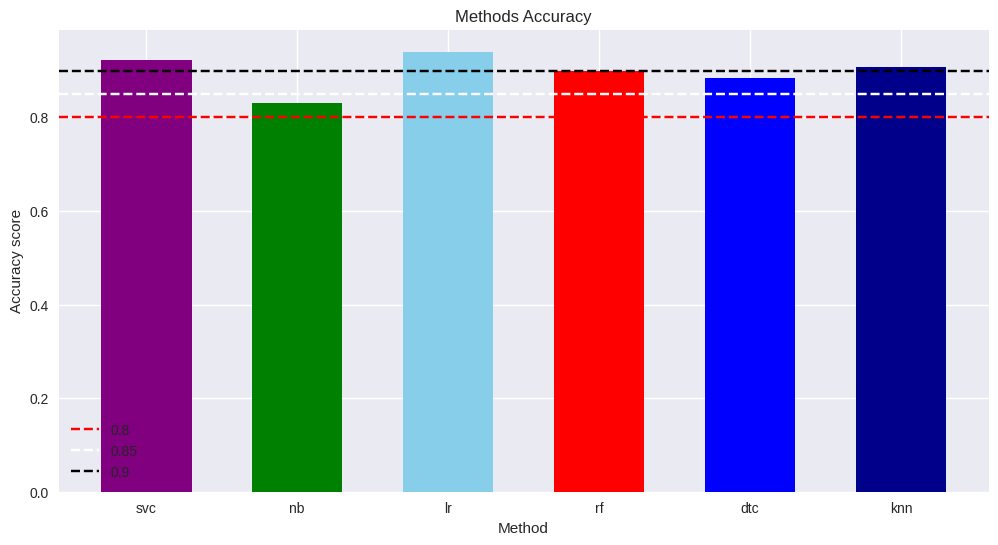

In [101]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers,mean_test_accuracy.values(),width=0.6, color={'red','green','blue','purple', 'skyblue','darkblue'})
plt.title('Methods Accuracy')
plt.axhline(0.8,c='r',linestyle='--',label='0.8')
plt.axhline(0.85,c='w',linestyle='--',label='0.85')
plt.axhline(0.9,c='black',linestyle='--',label='0.9')
plt.legend()
plt.autoscale()
plt.xlabel('Method')
plt.ylabel('Accuracy score')
plt.show()

In [ ]:
print ('method', '\t', 'train accuracy', '\t', 'test accuracy', '\n')
for i in classifiers:
    print (i, '\t', mean_train_accuracy[i], '\t', mean_test_accuracy[i])